# S1D1: Integrate GEX and ADT annotation and Trajectory analysis

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import os

In [2]:
plt.rcParams['figure.figsize'] = (8,8)

In [3]:
pd.options.display.max_columns=50

# Load ADT and RNA

In [4]:
os.getcwd()

'/home/jovyan/project/neurips2021-notebooks-private/notebooks/analysis/cite/s1d1'

In [5]:
os.chdir('/home/jovyan/project/neurips2021-notebooks-private/')

In [6]:
adata_adt = sc.read('data/s1d1/cite/s1d1_ADT_unmerged.h5ad')
adata_rna = sc.read('data/s1d1/cite/s1d1_GEX_unmerged.h5ad')

# Merge datasets

Note on doublets: We filtered out doublet in the GEX processing. In CITE data, doublet removal seems to be less successful. Therefore, we rely on the doublet detection in the GEX data and remove them by getting the cells shared between both data sets.

In [7]:
common_barcodes = list(set(adata_rna.obs_names).intersection(adata_adt.obs_names))
adata_rna_sub = adata_rna[common_barcodes].copy()
adata_adt_sub = adata_adt[common_barcodes].copy()

In [8]:
adata_rna_sub.obs['adt_ann'] = adata_adt_sub.obs['leiden_final']
adata_adt_sub.obs['rna_ann'] = adata_rna_sub.obs['leiden_final']

# Merge leiden_finals

Here, we plot the celltype annotation based on the two modalities on the UMAP representation of each. Thereby we can assess how well the annotation of one modality matches the data structure in the other modality. This gives us a first overview where one modality containes additional substructure compared to the other.

For each celltype, we try to find the modality the represents a cleaner and more fine grained clustering. E.g. for T cells, the clusters are better separated in the CITE data (CD4+ vs CD8+), while for the Erythocyte linage additional substructure is found in the GEX data.

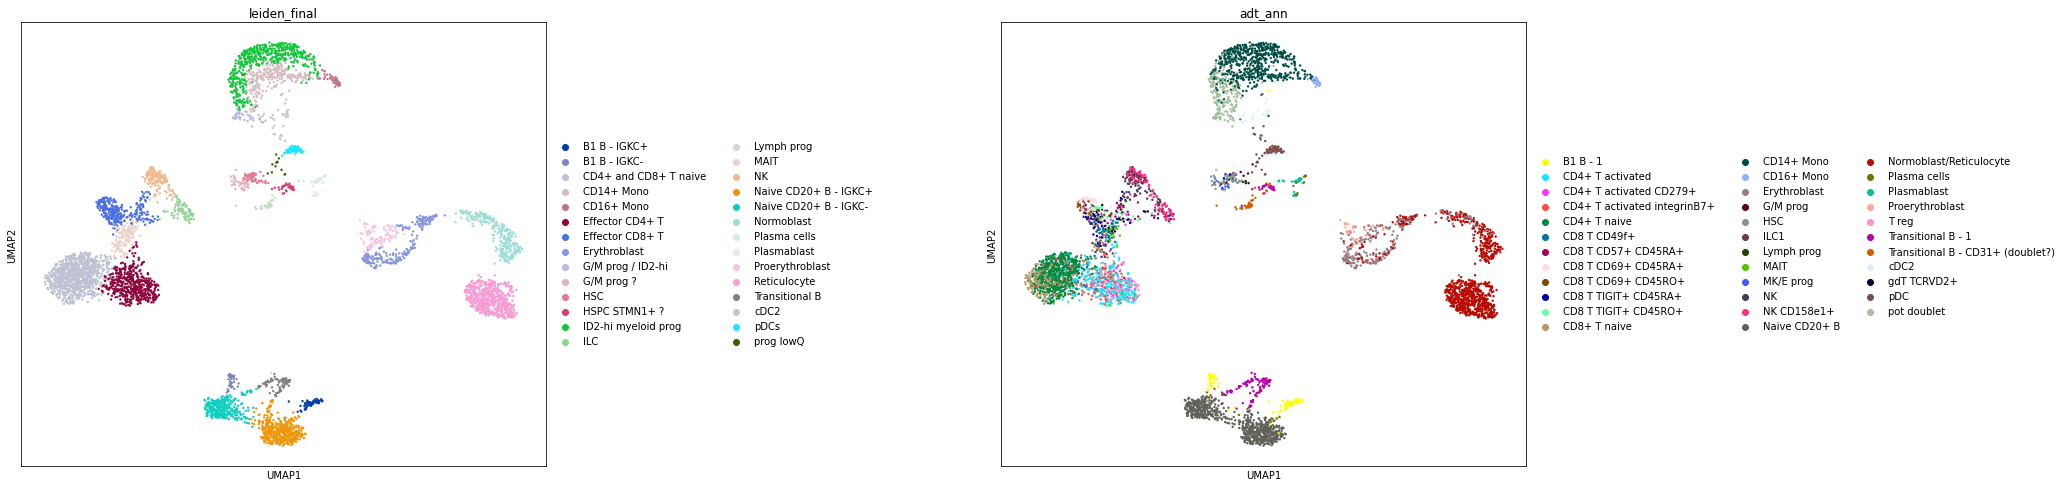

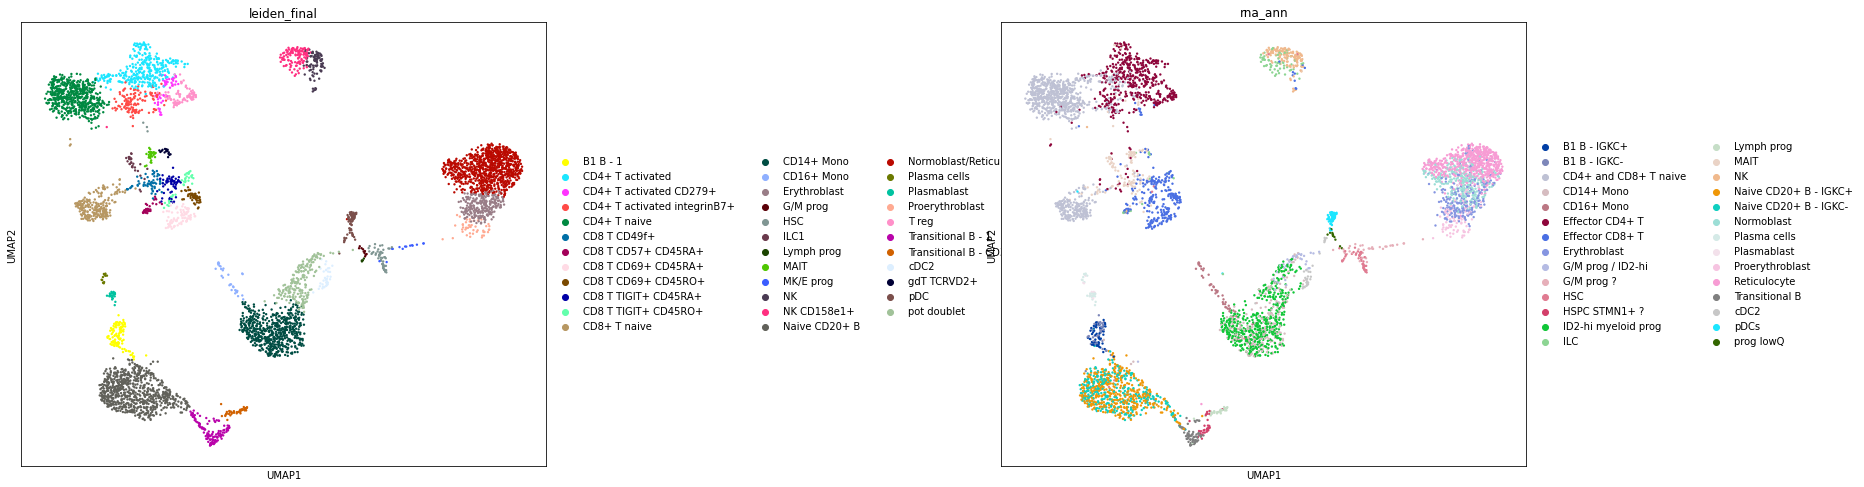

In [9]:
sc.pl.umap(adata_rna_sub, color=['leiden_final', 'adt_ann'], wspace=0.7)
sc.pl.umap(adata_adt_sub, color=['leiden_final', 'rna_ann'], wspace=0.7)

We then decide which modality should be the more determining one for each cell type:
- B cell leiden_finals better in RNA except Plasmablast/plasma cell
- Erythrocytes/reticulocytes better in RNA
- Monocytes better in RNA
- pDC in RNA, cDC2 in ADT
- Progenitors not clearly better in one
- T cells better in ADT
- NK cells better in ADT

## Crosstab leiden_finals

We now dive into details and check which cell type in one modality corresponds to the celltype in the second.

We look for differing annotations and check those with marker genes for each modality below. Thereby, we take a final decision for each celltype, which annotation we will use.

In [10]:
# Note: First argument corresponds to rows (here, RNA), second argument to columns (here: ADT)
pd.crosstab(adata_rna_sub.obs['leiden_final'], adata_adt_sub.obs['leiden_final'])

leiden_final,B1 B - 1,CD4+ T activated,CD4+ T activated CD279+,CD4+ T activated integrinB7+,CD4+ T naive,CD8 T CD49f+,CD8 T CD57+ CD45RA+,CD8 T CD69+ CD45RA+,CD8 T CD69+ CD45RO+,CD8 T TIGIT+ CD45RA+,CD8 T TIGIT+ CD45RO+,CD8+ T naive,CD14+ Mono,CD16+ Mono,Erythroblast,G/M prog,HSC,ILC1,Lymph prog,MAIT,MK/E prog,NK,NK CD158e1+,Naive CD20+ B,Normoblast/Reticulocyte,Plasma cells,Plasmablast,Proerythroblast,T reg,Transitional B - 1,Transitional B - CD31+ (doublet?),cDC2,gdT TCRVD2+,pDC,pot doublet
leiden_final,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B1 B - IGKC+,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B1 B - IGKC-,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
CD4+ and CD8+ T naive,0,71,3,28,586,4,0,0,0,0,0,209,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
CD14+ Mono,1,0,0,0,0,0,0,0,0,0,0,0,184,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,53
CD16+ Mono,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Effector CD4+ T,0,256,33,92,4,7,0,0,0,0,0,6,0,0,0,0,3,5,0,3,0,0,0,0,0,0,0,0,86,0,0,0,0,0,0
Effector CD8+ T,0,0,7,0,1,10,22,85,55,46,33,1,0,0,0,0,0,1,0,0,0,8,1,0,0,0,0,0,1,0,0,0,6,0,0
Erythroblast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,146,0,0,0,0,0,0,0,0,0,75,0,0,7,0,0,0,0,0,0,0
G/M prog / ID2-hi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,6,0,0,35


### Load marker genes

In case in your analysis other markers showed up, we can add them here as well

In [11]:
#RNA
marker_genes_rna = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'S100A9', 'CLEC12A', 'KLF4', 'PLAUR'],
    'cDC1': ['CLEC9A', 'CADM1'],
    'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'], # TFRC negative
    'Normoblast': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],  # 
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers   # CRACD as well, but not present in data
    'NK': ['GNLY', 'NKG7', 'CD247', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'], # GRIK4 as well, but not present in data
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],  # new: STMN1
    'naive CD20+ B - IGKC+':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'],
    'naive CD20+ B - IGKC-':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'], # IGKC negative
    'B1 B - IGKC+':['MS4A1', 'SSPN', 'ITGB1','IGKC', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'],# Note IGHD and IGHM are negative markers
    'B1 B - IGKC-':['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM', 'IGKC'],# Note IGKC, IGHD and IGHM are negative markers
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cells': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'Plasmablast': ['XBP1', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker   # RF4 as well, but not present in data
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
    'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'T activation': ['CD69', 'CD38'], # CD69 much better marker!
    'T naive': ['LEF1', 'CCR7', 'TCF7'],
    'pDCs': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'], 
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'], 
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'PLCB1'], # 'RYR3' as well,  but not present in data
    'HSPC STMN1+':['STMN1', 'HMGB1'] # newly characterized
}

#ADT

marker_genes_adt = {
    
    'CD14+ Mono': ['CD14', 'CD11b', 'CD62P'],
    'CD16+ Mono': ['CD85j', 'CD11c', 'CD172a', 'CD88'],
    'cDC2': ['CD1c', 'FceRIa', 'CD11c'],
    'pDC': ['CD303', 'CD304'], 
    
    #Ery linage
    'Proerythroblast': ['CD105'],
    'Erythroblast': ['CD82', 'CD71'], # CD82 also in B
    'Normoblast/Reticulocyte': ['CD71'], 

    # B linage
    'naive CD20+ B': ['IgD'],
    'B1 B': ['CD40', 'CD35', 'CD268', 'IgD'], # (IgD- !)
    'transitional B': ['CD38', 'CD24'], # 'CD24', 'CD81', 'CD9'
    'Plasma cell': ['CD63', 'CD319'], 
    'Plasmablast': ['CD39', 'CD319'], # CD86
    
    #NK
    'NK': ['CD56', 'CD94', 'CD335'],  # 'CD57'?
    'NK CD158e1+':['CD158e1'],
    
    # Progenitors
    'MK/E prog':['CD105', 'CD112', 'CD352'],
    'HSC': ['CD112', 'CD13', 'CD155'],
    'Lymph prog':['CD112', 'CD81'], # close to HSC
    'G/M prog':['CD112', 'CD86'],
    
    #CD4
    'CD4+ T naive':['CD45RA','CD4'], # close to HSC
    'T reg':['CD25', 'CD39', 'CD4'],
    'CD4+ T activated':['CD45RO','CD4'], # none of CD279+, CD194+, integrinB7+, CD314+
    'CD4+ T activated CD279+':['CD279','CD45RO','CD4', 'CD25'], #CD25 negative
    'CD4+ T activated CD194+':['CD194','CD45RO','CD4'],
    'CD4+ T activated integrinB7+':['integrinB7','CD45RO','CD4'],
    'CD4+ T CD314+ CD45RA+':['CD11c','CD314','CD45RA','CD4'], # 'CD11c' negative
    
    # CD8, gdT and other
    'CD8+ T naive CD127+ CD26+ CD101+':['CD127','CD26','CD101','CD45RA','CD8'],
    'CD8+ T naive CD127+ CD26- CD101-':['CD127','CD26','CD101','CD45RA','CD8'],
    
    'ILC1':['CD103', 'CD127'],
    'MAIT':['TCRVa7.2', 'CD8'],
    'gdT TCRVD2+':['TCRVd2','CD161'],
    
    'gdT CD56+':['CD56','CD158b'],
    'gdT Vd1 CD57+':['CD57','CD158b'],
    'gdT CD158b+ CD11c+':['CD158b','CD11c'],
    
    'CD8+ T CD49f+':['CD49f','CD226', 'CD45RO'], # only CD45RO+
    'CD8+ T CD57+ CD45RO+':['CD57', 'CD45RO'], # CD56-
    'CD8+ T CD57+ CD45RA+':['CD57','CD56', 'CD45RA'],
    'CD8+ T TIGIT+ CD45RO+':['TIGIT','CD45RO'], # also CD226-
    'CD8+ T TIGIT+ CD45RA+':['TIGIT','CD45RA'], #
    'CD8+ T CD69+ CD45RO+':['CD69','CD45RO'], # also CD226-
    'CD8+ T CD69+ CD45RA+':['CD69','CD45RA'], # 


}

In [12]:
marker_genes_rna.keys()

dict_keys(['CD14+ Mono', 'CD16+ Mono', 'ID2-hi myeloid prog', 'cDC1', 'cDC2', 'Reticulocyte', 'Normoblast', 'Erythroblast', 'Proerythroblast', 'NK', 'ILC', 'Lymph prog', 'naive CD20+ B - IGKC+', 'naive CD20+ B - IGKC-', 'B1 B - IGKC+', 'B1 B - IGKC-', 'Transitional B', 'Plasma cells', 'Plasmablast', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'T activation', 'T naive', 'pDCs', 'G/M prog', 'HSC', 'MK/E prog', 'HSPC STMN1+'])

In [13]:
marker_genes_adt.keys()

dict_keys(['CD14+ Mono', 'CD16+ Mono', 'cDC2', 'pDC', 'Proerythroblast', 'Erythroblast', 'Normoblast/Reticulocyte', 'naive CD20+ B', 'B1 B', 'transitional B', 'Plasma cell', 'Plasmablast', 'NK', 'NK CD158e1+', 'MK/E prog', 'HSC', 'Lymph prog', 'G/M prog', 'CD4+ T naive', 'T reg', 'CD4+ T activated', 'CD4+ T activated CD279+', 'CD4+ T activated CD194+', 'CD4+ T activated integrinB7+', 'CD4+ T CD314+ CD45RA+', 'CD8+ T naive CD127+ CD26+ CD101+', 'CD8+ T naive CD127+ CD26- CD101-', 'ILC1', 'MAIT', 'gdT TCRVD2+', 'gdT CD56+', 'gdT Vd1 CD57+', 'gdT CD158b+ CD11c+', 'CD8+ T CD49f+', 'CD8+ T CD57+ CD45RO+', 'CD8+ T CD57+ CD45RA+', 'CD8+ T TIGIT+ CD45RO+', 'CD8+ T TIGIT+ CD45RA+', 'CD8+ T CD69+ CD45RO+', 'CD8+ T CD69+ CD45RA+'])

**Which annotation to be used per celltype**

(Plotting specific marker genes for clarification below)

From RNA:
- CD14+ Mono
- CD16+ Mono
- pDCs

- Reticulocyte
- Normoblast
- Erythroblast
- Proerythroblast


- naive CD20+ B - IGKC+
- naive CD20+ B - IGKC-

- B1 B - IGKC+
- B1 B - IGKC-

- transitional B

- Lymph prog
- G/M prog
- HSC

From ADT:
- cDC2
- CD4+ T activated
- CD4+ T naive
- Treg
- CD8+ T activated
- CD8+ T activated TIGIT+
- CD8+ T activated CD69+
- CD8+ T naive
- gdT
- NKT
- NK
- ILC
- Plasma cells
- Plasmablast


Notes:
- RNA HSPC/Lymph prog? absorbed into other clusters
- RNA Transitional B has RNA substructure


### Check out specific celltypes

Check out cell type markers in each modality to see which clusters are more disctinct. Here we plot RNA and ADT markers on both representations.

Markers on RNA


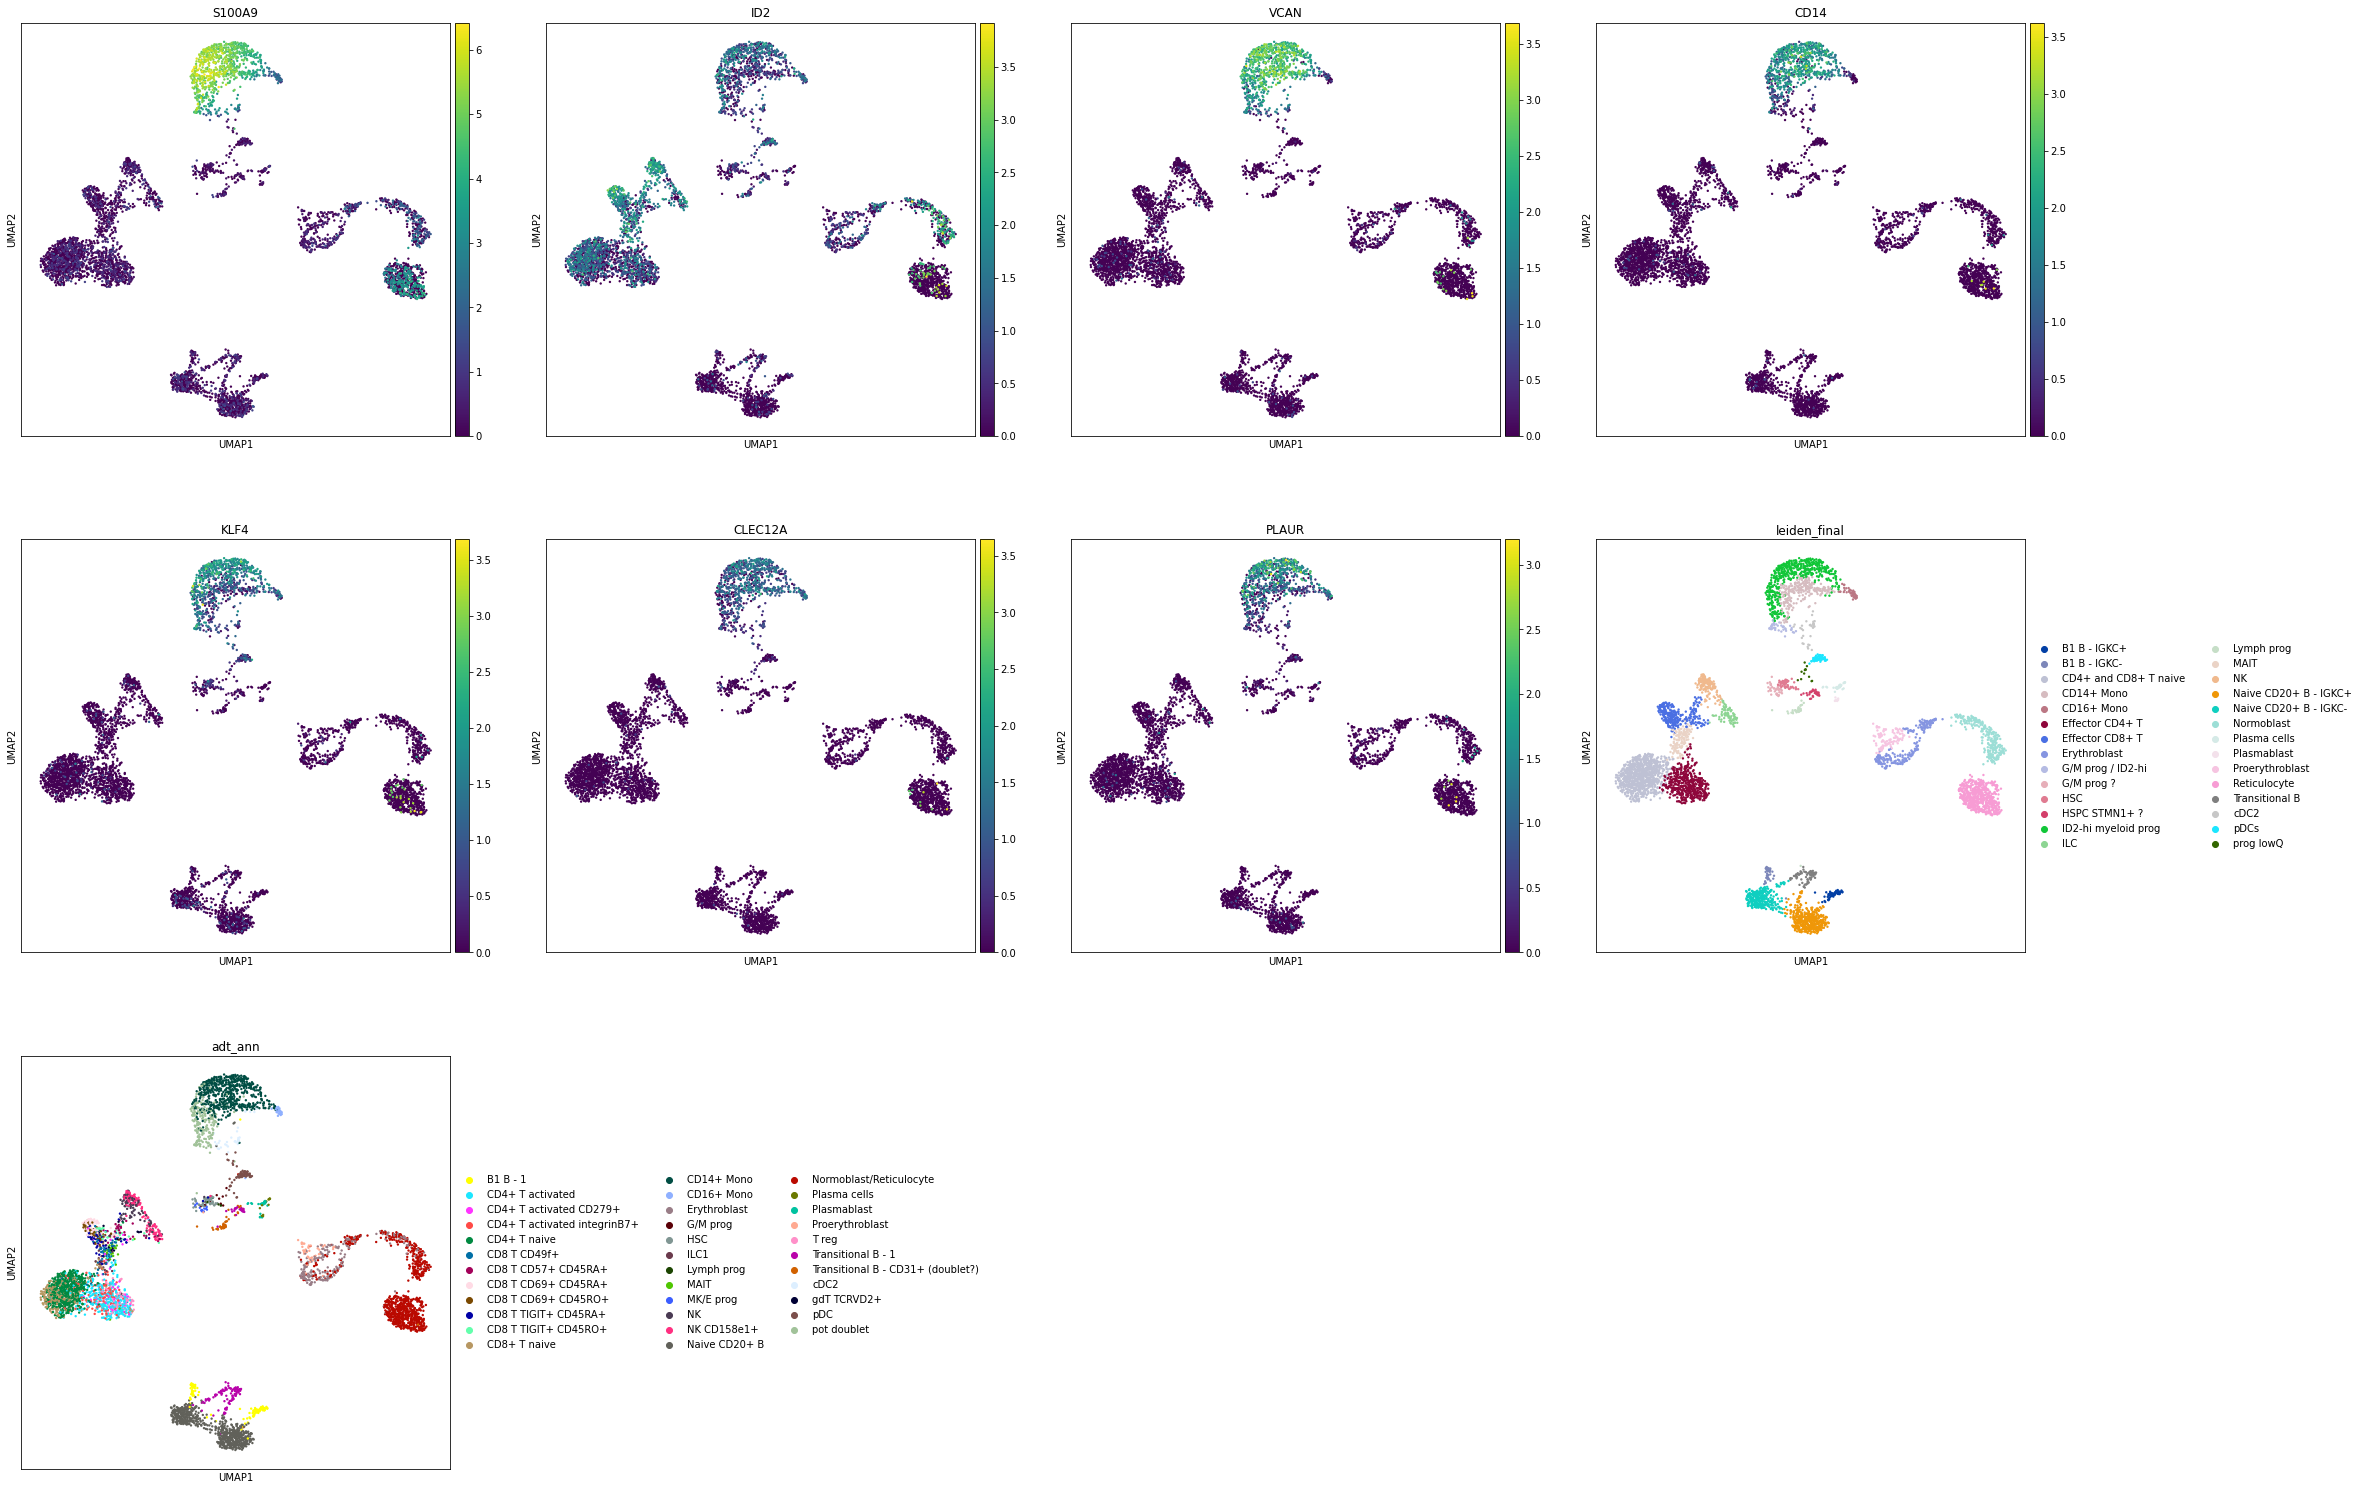

Markers on ADT


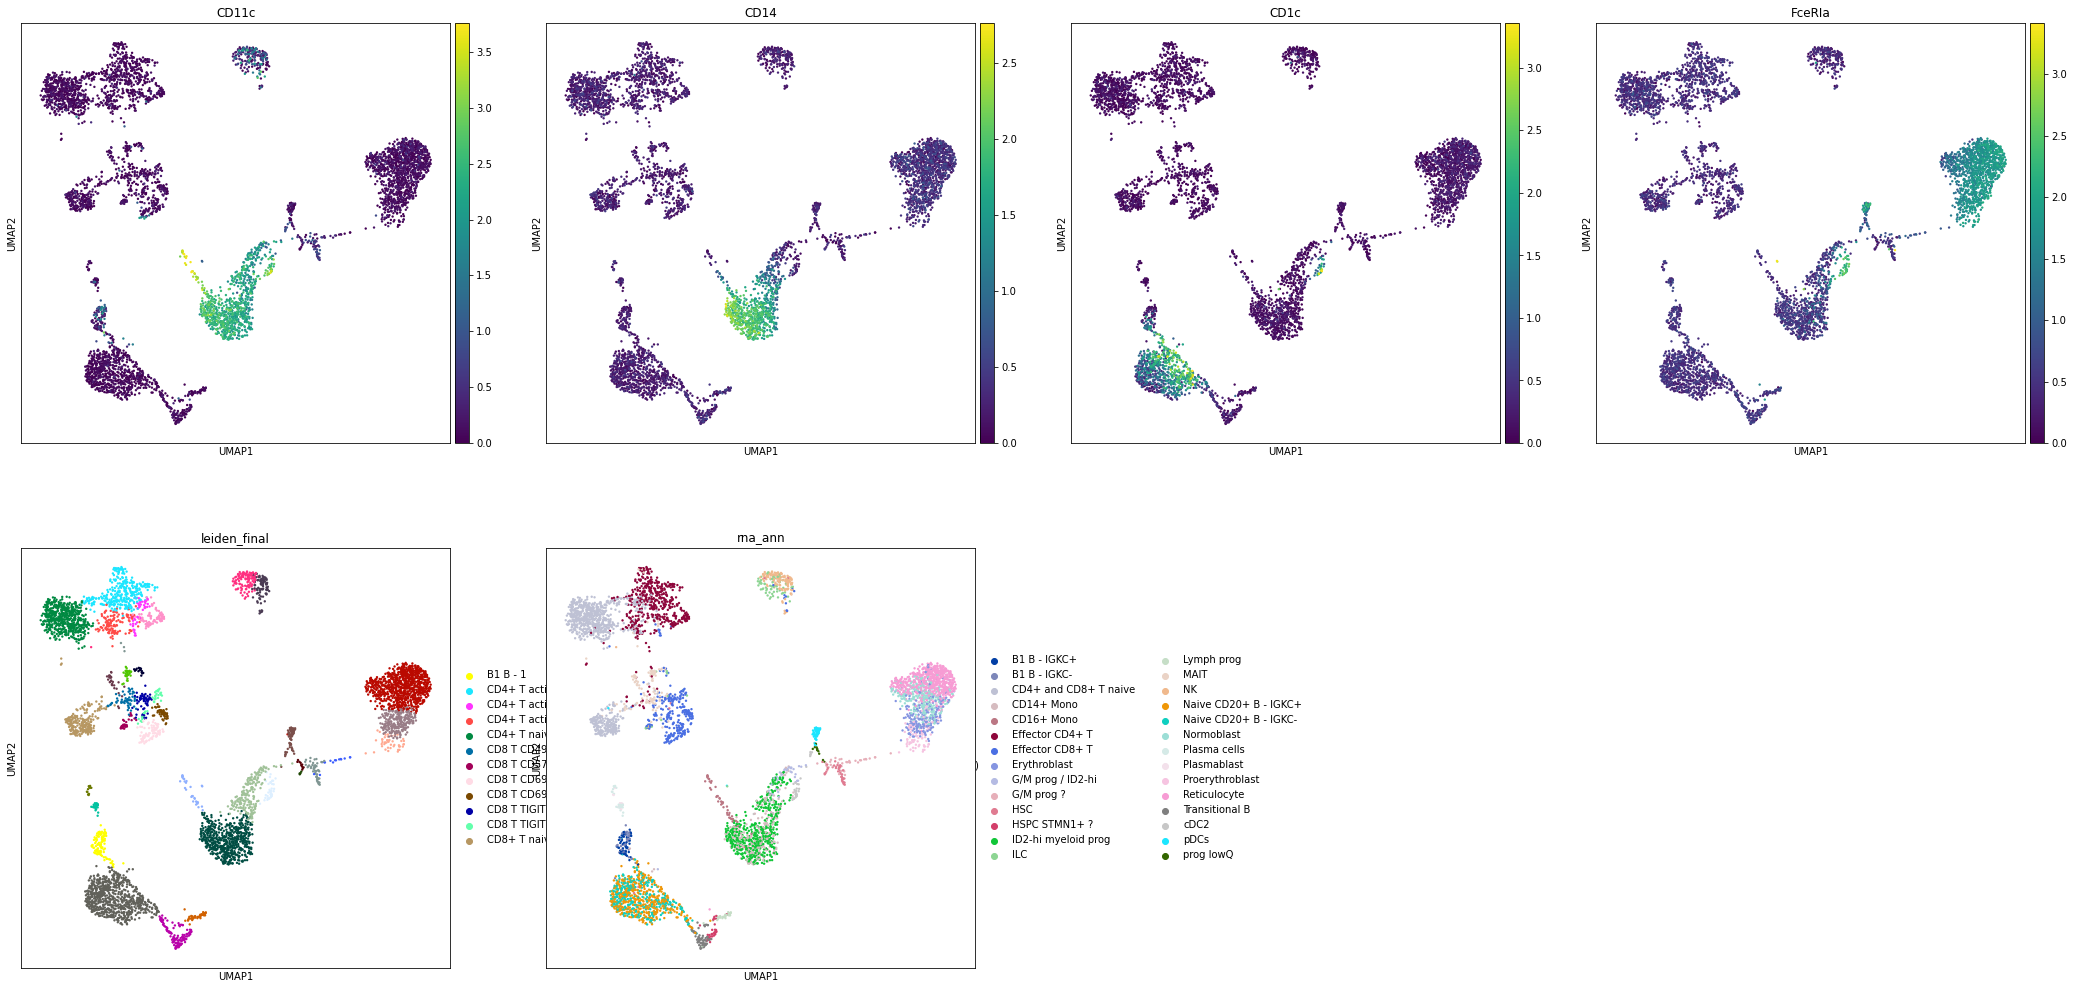

In [14]:
# select celltypes to compare
rna_ct = 'ID2-hi myeloid prog'
adt_ct = 'cDC2'

genes = marker_genes_rna[rna_ct]+marker_genes_adt[adt_ct]
ann_key_r = 'leiden_final'
ann_key_a = 'leiden_final'

genes_r = [g for g in adata_rna_sub.var_names if str(g) in genes ]
genes_a = [g for g in adata_adt_sub.var_names if str(g) in genes]

print('Markers on RNA')
sc.pl.umap(adata_rna_sub, color=genes_r+[ann_key_r, 'adt_ann'])

print('Markers on ADT')
sc.pl.umap(adata_adt_sub, color=genes_a+[ann_key_a, 'rna_ann'])

if len(genes) < 3:
    plt.rcParams['figure.figsize'] = (24,8)
    sc.pl.violin(adata_adt_sub, keys=genes_a, groupby=ann_key_a)
    plt.rcParams['figure.figsize'] = (8,8)

Additional highlighting of selected clusters (e.g. in case you can't identify particular clusters from the ADT or RNA plots due to bad coloring)

... storing 'test' as categorical


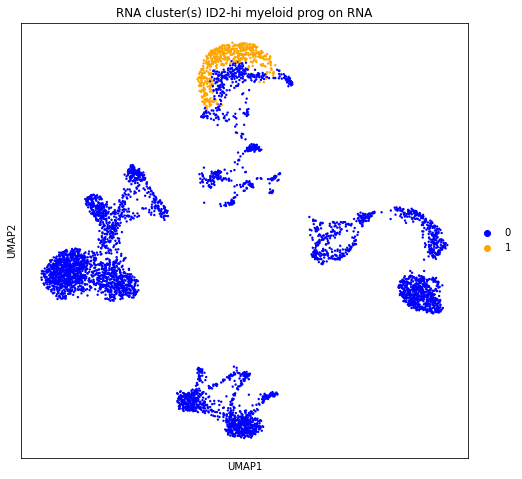

... storing 'test' as categorical


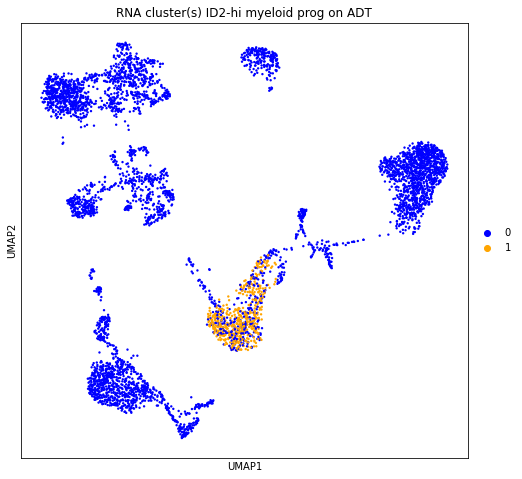

... storing 'test' as categorical


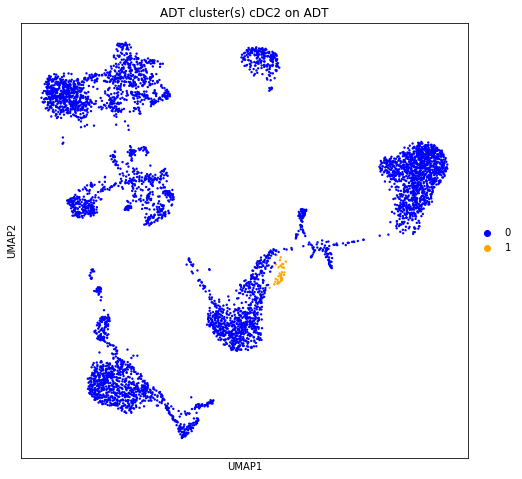

... storing 'test' as categorical


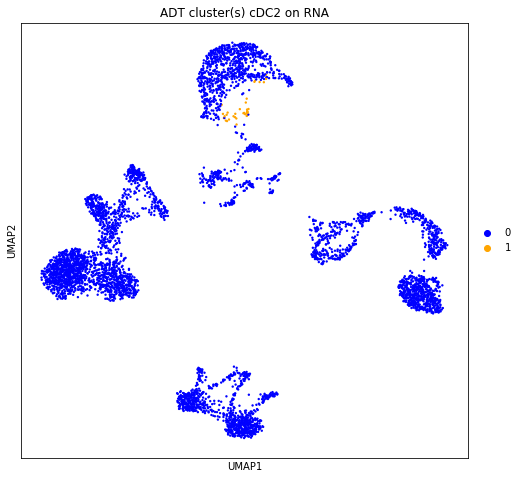

In [15]:
#RNA clusters
#-------------
# Use celltype from above
clusts = [rna_ct]
# Or selct new ones
#clusts = ['HSPC/Lymph prog?']

adata_rna_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_rna_sub.obs['leiden_final']]
sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'RNA cluster(s) '+ '; '.join(clusts) + ' on RNA')
adata_adt_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_adt_sub.obs['rna_ann']]
sc.pl.umap(adata_adt_sub, color='test', palette=['blue', 'orange'],
          title = 'RNA cluster(s) '+ '; '.join(clusts) + ' on ADT')


#ADT clusters
#--------------
# Use celltype from above
clusts = [adt_ct]
# Or selct new ones
#clusts = ['HSPC']

adata_adt_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_adt_sub.obs['leiden_final']]
sc.pl.umap(adata_adt_sub, color='test', palette=['blue', 'orange'],
          title = 'ADT cluster(s) '+ '; '.join(clusts) + ' on ADT')
adata_rna_sub.obs['test'] = ['1' if ct in clusts else '0' for ct in adata_rna_sub.obs['adt_ann']]
sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'ADT cluster(s) '+ '; '.join(clusts) + ' on RNA')



## Create a final merged celltype annotation

In [16]:
# List RNA celltypes
set(adata_rna_sub.obs['leiden_final'])

{'B1 B - IGKC+',
 'B1 B - IGKC-',
 'CD14+ Mono',
 'CD16+ Mono',
 'CD4+ and CD8+ T naive',
 'Effector CD4+ T',
 'Effector CD8+ T',
 'Erythroblast',
 'G/M prog / ID2-hi',
 'G/M prog ?',
 'HSC',
 'HSPC STMN1+ ?',
 'ID2-hi myeloid prog',
 'ILC',
 'Lymph prog',
 'MAIT',
 'NK',
 'Naive CD20+ B - IGKC+',
 'Naive CD20+ B - IGKC-',
 'Normoblast',
 'Plasma cells',
 'Plasmablast',
 'Proerythroblast',
 'Reticulocyte',
 'Transitional B',
 'cDC2',
 'pDCs',
 'prog lowQ'}

In [17]:
# List ADT celltypes
set(adata_adt_sub.obs['leiden_final'])

{'B1 B - 1',
 'CD14+ Mono',
 'CD16+ Mono',
 'CD4+ T activated',
 'CD4+ T activated CD279+',
 'CD4+ T activated integrinB7+',
 'CD4+ T naive',
 'CD8 T CD49f+',
 'CD8 T CD57+ CD45RA+',
 'CD8 T CD69+ CD45RA+',
 'CD8 T CD69+ CD45RO+',
 'CD8 T TIGIT+ CD45RA+',
 'CD8 T TIGIT+ CD45RO+',
 'CD8+ T naive',
 'Erythroblast',
 'G/M prog',
 'HSC',
 'ILC1',
 'Lymph prog',
 'MAIT',
 'MK/E prog',
 'NK',
 'NK CD158e1+',
 'Naive CD20+ B',
 'Normoblast/Reticulocyte',
 'Plasma cells',
 'Plasmablast',
 'Proerythroblast',
 'T reg',
 'Transitional B - 1',
 'Transitional B - CD31+ (doublet?)',
 'cDC2',
 'gdT TCRVD2+',
 'pDC',
 'pot doublet'}

In [18]:
# Chose celltype from each modality:

celltype_map_rna = {
    
    'CD14+ Mono':'CD14+ Mono',
    'CD16+ Mono':'CD16+ Mono',
    'ID2-hi myeloid prog':'ID2-hi myeloid prog',
    
    'Reticulocyte':'Reticulocyte',
    'Normoblast':'Normoblast',
    'Erythroblast':'Erythroblast',
    'Proerythroblast':'Proerythroblast',
    
    #'G/M prog ?':'G/M prog',
    #'HSC':'HSC',
    'Lymph prog':'Lymph prog',
    'HSPC STMN1+ ?':'Lymph prog',
    
    'Naive CD20+ B - IGKC+':'Naive CD20+ B IGKC+',
    'Naive CD20+ B - IGKC-':'Naive CD20+ B IGKC-',
    'B1 B - IGKC+':'B1 B IGKC+',
    'B1 B - IGKC-':'B1 B IGKC-',
    'Transitional B':'Transitional B',

    'pDCs':'pDC'
    
}
celltype_map_adt = {
    
    'CD4+ T activated':'CD4+ T activated',
    'CD4+ T activated CD279+':'CD4+ T activated CD279+',
    'CD4+ T activated integrinB7+':'CD4+ T activated integrinB7+',
    'CD4+ T naive':'CD4+ T naive',
    'CD8 T CD49f+':'CD8 T CD49f+',
    'CD8 T CD57+ CD45RA+':'CD8 T CD57+ CD45RA+',
    'CD8 T CD69+ CD45RA+':'CD8 T CD69+ CD45RA+',
    'CD8 T CD69+ CD45RO+':'CD8 T CD69+ CD45RO+',
    'CD8 T TIGIT+ CD45RA+':'CD8 T TIGIT+ CD45RA+',
    'CD8 T TIGIT+ CD45RO+':'CD8 T TIGIT+ CD45RO+',
    'CD8+ T naive':'CD8+ T naive',
    
    'T reg':'T reg',
    'gdT TCRVD2+':'gdT TCRVD2+',
    'ILC1':'ILC1',
    'NK':'NK',
    'NK CD158e1+':'NK CD158e1+',
    'MAIT':'MAIT',
    #'Plasma cells':'Plasma cell',
    #'Plasmablast':'Plasmablast',
    'cDC2':'cDC2',
    
    'G/M prog':'G/M prog',
    'MK/E prog':'MK/E prog',
    'HSC':'HSC',
    
}

rna_cts = list(celltype_map_rna.keys())
adt_cts = list(celltype_map_adt.keys())

Create new colomn with selected celltypes and add **'Oh god'** for cells that are not part of one of the selected celltype clusters:

In [19]:
new_celltype_ann = []

for idx in adata_rna_sub.obs_names:
    rna_ct = adata_rna_sub.obs['leiden_final'][idx]
    adt_ct = adata_adt_sub.obs['leiden_final'][idx]
    
    if adt_ct in adt_cts:
        new_celltype_ann.append(celltype_map_adt[adt_ct])
    elif rna_ct in rna_cts:
        new_celltype_ann.append(celltype_map_rna[rna_ct])
    else:
        new_celltype_ann.append('Oh god')

final_ann_df = pd.Series(index=adata_rna_sub.obs_names, data=new_celltype_ann)        
        
adata_rna_sub.obs['celltype'] = final_ann_df
adata_adt_sub.obs['celltype'] = final_ann_df

In [20]:
# Number of cells per celltype
adata_rna_sub.obs['celltype'].value_counts()

Reticulocyte                    605
CD4+ T naive                    591
ID2-hi myeloid prog             494
Naive CD20+ B IGKC+             454
CD4+ T activated                332
Naive CD20+ B IGKC-             316
Normoblast                      266
CD14+ Mono                      240
CD8+ T naive                    229
Erythroblast                    228
CD4+ T activated integrinB7+    124
NK CD158e1+                     119
Oh god                          103
Proerythroblast                 100
NK                               94
T reg                            88
CD8 T CD69+ CD45RA+              87
Transitional B                   76
Lymph prog                       67
CD8 T TIGIT+ CD45RA+             58
HSC                              58
CD8 T CD49f+                     58
B1 B IGKC+                       57
pDC                              57
CD8 T CD69+ CD45RO+              55
CD4+ T activated CD279+          49
CD16+ Mono                       45
B1 B IGKC-                  

Now we need to take a closer look at the **'Oh god'** cells.

We do so by checking the celltypes per modality, **'Oh god'** cells come from:

In [21]:
# Comparison of final celltypes with RNA celltypes
pd.crosstab(adata_rna_sub.obs['celltype'], adata_rna_sub.obs['leiden_final'])

leiden_final,B1 B - IGKC+,B1 B - IGKC-,CD4+ and CD8+ T naive,CD14+ Mono,CD16+ Mono,Effector CD4+ T,Effector CD8+ T,Erythroblast,G/M prog / ID2-hi,G/M prog ?,HSC,HSPC STMN1+ ?,ID2-hi myeloid prog,ILC,Lymph prog,MAIT,NK,Naive CD20+ B - IGKC+,Naive CD20+ B - IGKC-,Normoblast,Plasma cells,Plasmablast,Proerythroblast,Reticulocyte,Transitional B,cDC2,pDCs,prog lowQ
celltype,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B1 B IGKC+,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B1 B IGKC-,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CD14+ Mono,0,0,0,240,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CD16+ Mono,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CD4+ T activated,0,0,71,0,0,256,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
CD4+ T activated CD279+,0,0,3,0,0,33,7,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0
CD4+ T activated integrinB7+,0,0,28,0,0,92,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0
CD4+ T naive,0,0,586,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CD8 T CD49f+,0,0,4,0,0,7,10,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
# Comparison of final celltypes with ADT celltypes
pd.crosstab(adata_adt_sub.obs['celltype'], adata_adt_sub.obs['leiden_final'])

leiden_final,B1 B - 1,CD4+ T activated,CD4+ T activated CD279+,CD4+ T activated integrinB7+,CD4+ T naive,CD8 T CD49f+,CD8 T CD57+ CD45RA+,CD8 T CD69+ CD45RA+,CD8 T CD69+ CD45RO+,CD8 T TIGIT+ CD45RA+,CD8 T TIGIT+ CD45RO+,CD8+ T naive,CD14+ Mono,CD16+ Mono,Erythroblast,G/M prog,HSC,ILC1,Lymph prog,MAIT,MK/E prog,NK,NK CD158e1+,Naive CD20+ B,Normoblast/Reticulocyte,Plasma cells,Plasmablast,Proerythroblast,T reg,Transitional B - 1,Transitional B - CD31+ (doublet?),cDC2,gdT TCRVD2+,pDC,pot doublet
celltype,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B1 B IGKC+,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B1 B IGKC-,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
CD14+ Mono,1,0,0,0,0,0,0,0,0,0,0,0,184,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,53
CD16+ Mono,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CD4+ T activated,0,332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CD4+ T activated CD279+,0,0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CD4+ T activated integrinB7+,0,0,0,124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CD4+ T naive,0,0,0,0,591,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CD8 T CD49f+,0,0,0,0,0,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Resolve unannotated cells

This includes
- Remaining clusters that were not included in final annotation at all (e.g. high count - T doublet from ADT, which we assign to CD4+ T naive (also given the RNA annotation)
- Subsets of clusters that were not defined in the final celltypes. It is helpful to check again where the unassigned cells might come from. Depending on whether an association with a certain celltype can be made, they should be labeled accordingly or be removed.

In [23]:
# Plot specific 'Oh god' cells

# in RNA
clust = ['Plasmablast']

test_vec_rna = []

for i,ct in enumerate(adata_rna_sub.obs['leiden_final']):
    
    if ct in clust:
        if adata_rna_sub.obs['celltype'][i]=='Oh god':
            test_vec_rna.append('1')
        else:
            test_vec_rna.append('0')
    else:
        test_vec_rna.append('0')

# in ADT
clust = ['Plasmablast']
test_vec_adt = []

for i,ct in enumerate(adata_adt_sub.obs['leiden_final']):
    
    if ct in clust:
        if adata_adt_sub.obs['celltype'][i]=='Oh god':
            test_vec_adt.append('1')
        else:
            test_vec_adt.append('0')
    else:
        test_vec_adt.append('0')

... storing 'test' as categorical
... storing 'celltype' as categorical


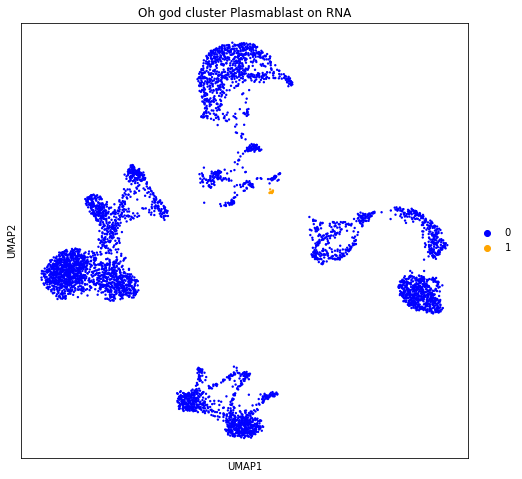

... storing 'test' as categorical
... storing 'celltype' as categorical


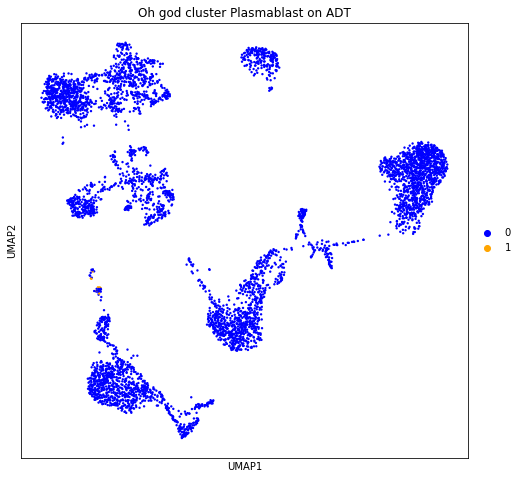

In [24]:
adata_rna_sub.obs['test'] = test_vec_rna
adata_adt_sub.obs['test'] = test_vec_rna

sc.pl.umap(adata_rna_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ clust[0] + ' on RNA')

sc.pl.umap(adata_adt_sub, color='test', palette=['blue', 'orange'],
          title = 'Oh god cluster '+ clust[0] + ' on ADT')

RNA:
- G/M prog / CD14+ Mono -> doublet? -> remove

- prog lowQ unclear... -> remove 

Add celltype for Oh god cells, where association is clear

In [25]:
# NOt applied in this one, but potentially helful for other

new_celltype_ann = []

for idx in adata_rna_sub.obs_names:
    given_ct = adata_rna_sub.obs['celltype'][idx]
    rna_ct = adata_rna_sub.obs['leiden_final'][idx]
    adt_ct = adata_adt_sub.obs['leiden_final'][idx]
    
    if given_ct == 'Oh god':
        if adt_ct == 'Plasma cells':
            if rna_ct == 'Plasmablast':
                new_celltype_ann.append('Plasma cell IGKC-')
            elif rna_ct == 'Plasma cells':
                new_celltype_ann.append('Plasma cell IGKC+')
            else:
                new_celltype_ann.append('Oh god')
                
        elif adt_ct == 'Plasmablast':
            if rna_ct == 'Plasmablast':
                new_celltype_ann.append('Plasmablast IGKC-')
            elif rna_ct == 'Plasma cells':
                new_celltype_ann.append('Plasmablast IGKC+')
            else:
                new_celltype_ann.append('Oh god')
        #     new_celltype_ann.append('HSPC')
        # Below would be adding a label if celltype association is clear
        #elif rna_ct == 'G/M prog':
        #    new_celltype_ann.append('Lymph prog')
        
        else:
            new_celltype_ann.append('Oh god')
    else:
        new_celltype_ann.append(given_ct)

final_ann_df = pd.Series(index=adata_rna_sub.obs_names, data=new_celltype_ann)        
        
adata_rna_sub.obs['celltype'] = final_ann_df
adata_adt_sub.obs['celltype'] = final_ann_df

In [26]:
adata_rna_sub.obs['celltype'].value_counts()

Reticulocyte                    605
CD4+ T naive                    591
ID2-hi myeloid prog             494
Naive CD20+ B IGKC+             454
CD4+ T activated                332
Naive CD20+ B IGKC-             316
Normoblast                      266
CD14+ Mono                      240
CD8+ T naive                    229
Erythroblast                    228
CD4+ T activated integrinB7+    124
NK CD158e1+                     119
Proerythroblast                 100
NK                               94
T reg                            88
CD8 T CD69+ CD45RA+              87
Transitional B                   76
Lymph prog                       67
Oh god                           66
CD8 T TIGIT+ CD45RA+             58
CD8 T CD49f+                     58
HSC                              58
B1 B IGKC+                       57
pDC                              57
CD8 T CD69+ CD45RO+              55
CD4+ T activated CD279+          49
CD16+ Mono                       45
B1 B IGKC-                  

### Remove unresolvable cells

Remove remaining Oh god cells

In [27]:
adata_rna_sub = adata_rna_sub[~adata_rna_sub.obs['celltype'].isin(['Oh god'])].copy()
adata_adt_sub = adata_adt_sub[~adata_adt_sub.obs['celltype'].isin(['Oh god'])].copy()

... storing 'celltype' as categorical


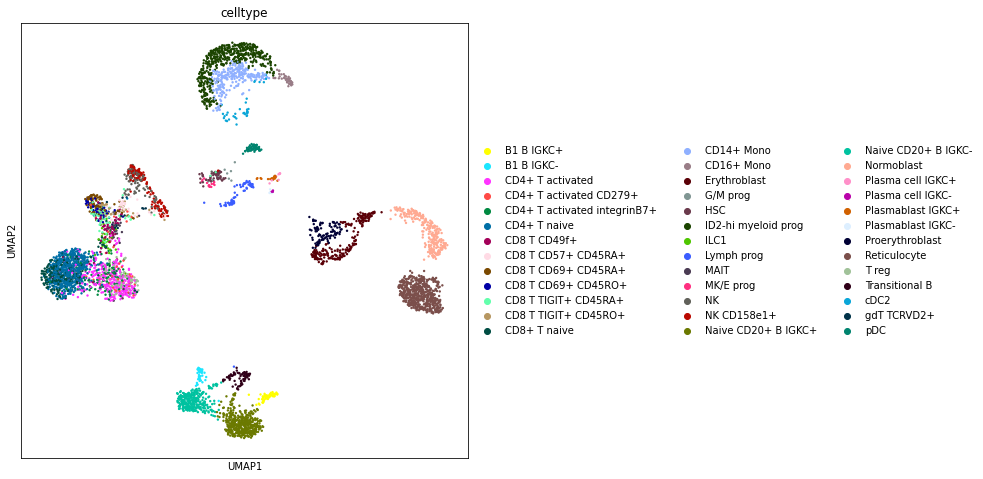

... storing 'celltype' as categorical


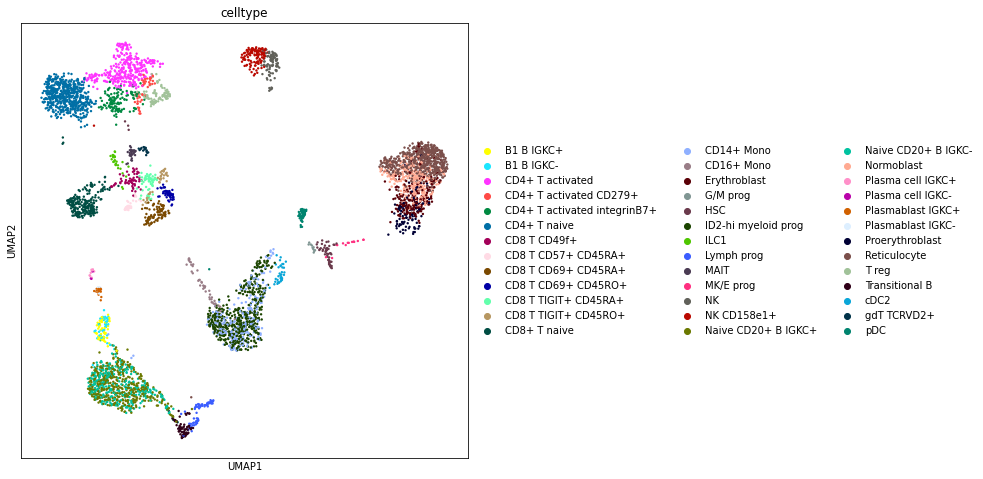

In [28]:
sc.pl.umap(adata_rna_sub, color='celltype')
sc.pl.umap(adata_adt_sub, color='celltype')

# Trajectories

## RNA Trajectory

In [29]:
adata_rna_sub.obs['celltype'].value_counts()

Reticulocyte                    605
CD4+ T naive                    591
ID2-hi myeloid prog             494
Naive CD20+ B IGKC+             454
CD4+ T activated                332
Naive CD20+ B IGKC-             316
Normoblast                      266
CD14+ Mono                      240
CD8+ T naive                    229
Erythroblast                    228
CD4+ T activated integrinB7+    124
NK CD158e1+                     119
Proerythroblast                 100
NK                               94
T reg                            88
CD8 T CD69+ CD45RA+              87
Transitional B                   76
Lymph prog                       67
CD8 T TIGIT+ CD45RA+             58
HSC                              58
CD8 T CD49f+                     58
B1 B IGKC+                       57
pDC                              57
CD8 T CD69+ CD45RO+              55
CD4+ T activated CD279+          49
CD16+ Mono                       45
B1 B IGKC-                       42
CD8 T TIGIT+ CD45RO+        

In [30]:
adata_rna_ery = adata_rna_sub[adata_rna_sub.obs['celltype'].isin(['HSC', 'Proerythroblast', 'Erythroblast', 'Normoblast','Reticulocyte'])].copy()

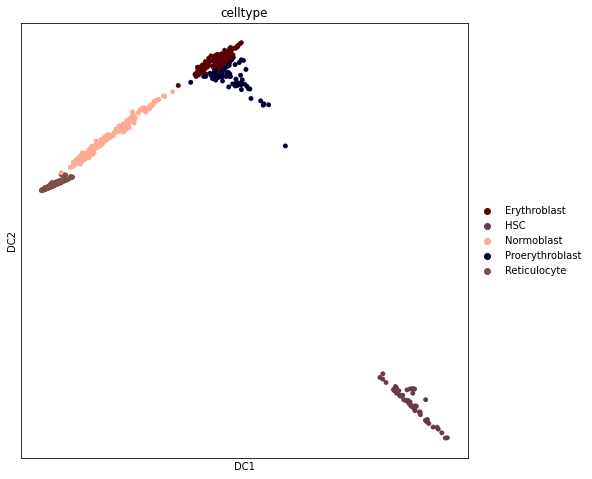

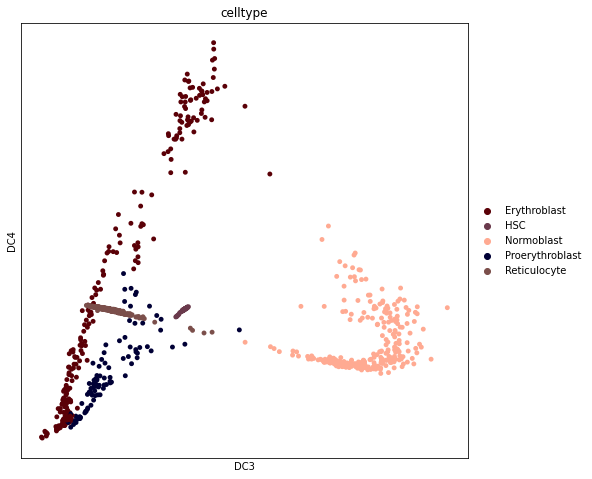

In [31]:
sc.pp.neighbors(adata_rna_ery)
sc.tl.diffmap(adata_rna_ery)
sc.pl.diffmap(adata_rna_ery, color='celltype', components='1,2', frameon=True)
sc.pl.diffmap(adata_rna_ery, color='celltype', components='3,4', frameon=True)

In [32]:
# Get DC1 min, DC2 max cell as root (most outer stem cell like cell)
# NOTE: argmax() or argmin() often needs to be reassigned for each run

c1 = adata_rna_ery.obsm['X_diffmap'][:,1].argmax()
c2 = c1 # adata_rna_ery.obsm['X_diffmap'][:,2].argmin()

correct root cell: GTAGAAAGTGACACAG-1


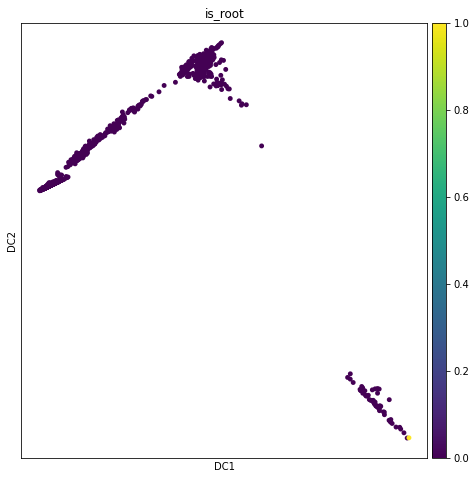

In [33]:
if c1 == c2:
    print(f'correct root cell: {adata_rna_ery.obs_names[c1]}')
    adata_rna_ery.uns['iroot'] = c1
    
    #check if correct
    adata_rna_ery.obs['is_root'] = [1 if idx==adata_rna_ery.obs_names[c1] else 0 for idx in adata_rna_ery.obs_names]
    sc.pl.diffmap(adata_rna_ery, color='is_root', components='1,2', frameon=True)
     

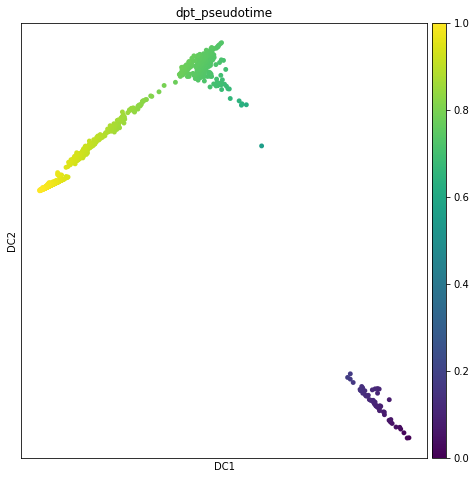

In [34]:
sc.tl.dpt(adata_rna_ery)
sc.pl.diffmap(adata_rna_ery, color='dpt_pseudotime', components='1,2', frameon=True)

In [35]:
# Transfer back to full object
adata_rna_sub.obs['pseudotime_order_GEX'] = adata_rna_ery.obs['dpt_pseudotime']

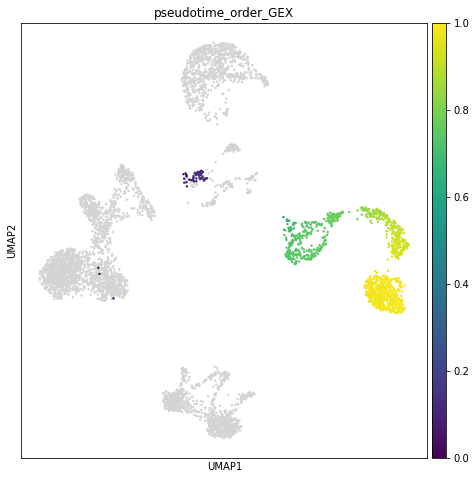

In [36]:
sc.pl.umap(adata_rna_sub, color='pseudotime_order_GEX')

## ADT Trajectory

In [37]:
adata_adt_sub.obs['celltype'].value_counts()

Reticulocyte                    605
CD4+ T naive                    591
ID2-hi myeloid prog             494
Naive CD20+ B IGKC+             454
CD4+ T activated                332
Naive CD20+ B IGKC-             316
Normoblast                      266
CD14+ Mono                      240
CD8+ T naive                    229
Erythroblast                    228
CD4+ T activated integrinB7+    124
NK CD158e1+                     119
Proerythroblast                 100
NK                               94
T reg                            88
CD8 T CD69+ CD45RA+              87
Transitional B                   76
Lymph prog                       67
CD8 T TIGIT+ CD45RA+             58
HSC                              58
CD8 T CD49f+                     58
B1 B IGKC+                       57
pDC                              57
CD8 T CD69+ CD45RO+              55
CD4+ T activated CD279+          49
CD16+ Mono                       45
B1 B IGKC-                       42
CD8 T TIGIT+ CD45RO+        

In [38]:
#adata_adt_ery = adata_adt_sub[adata_adt_sub.obs['celltype'].isin(['HSC', 'Proerythroblast', 'Erythroblast', 'Normoblast','Reticulocyte'])].copy()
adata_adt_ery = adata_adt_sub[adata_adt_sub.obs['celltype'].isin(['Proerythroblast', 'Erythroblast', 'Normoblast','Reticulocyte'])].copy()

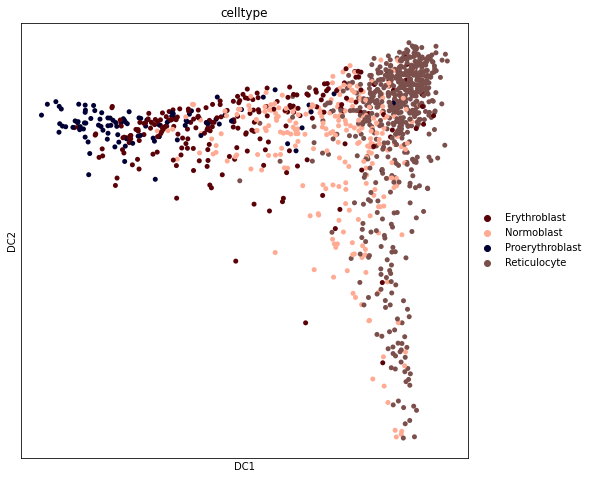

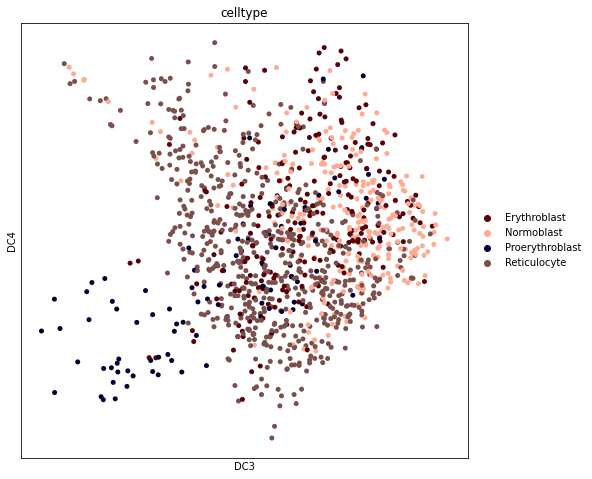

In [39]:
sc.pp.neighbors(adata_adt_ery,)
sc.tl.diffmap(adata_adt_ery)
sc.pl.diffmap(adata_adt_ery, color='celltype', components='1,2', frameon=True)
sc.pl.diffmap(adata_adt_ery, color='celltype', components='3,4', frameon=True)

In [40]:
adata_adt_ery

AnnData object with n_obs × n_vars = 1199 × 140
    obs: 'n_antibodies_by_counts', 'total_counts', 'iso_count', 'leiden_res0.5_sub', 'leiden_final', 'rna_ann', 'test', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts'
    uns: 'iso_count_fltr_colors', 'leiden', 'leiden_res0.3_colors', 'leiden_res0.5_colors', 'leiden_res0.5_sub_colors', 'leiden_res0.8_colors', 'leiden_res1_colors', 'leiden_temp_colors', 'neighbors', 'pca', 'predicted_doublet_colors', 'rank_leiden_res0.5', 'umap', 'leiden_final_colors', 'rna_ann_colors', 'test_colors', 'celltype_colors', 'diffmap_evals'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

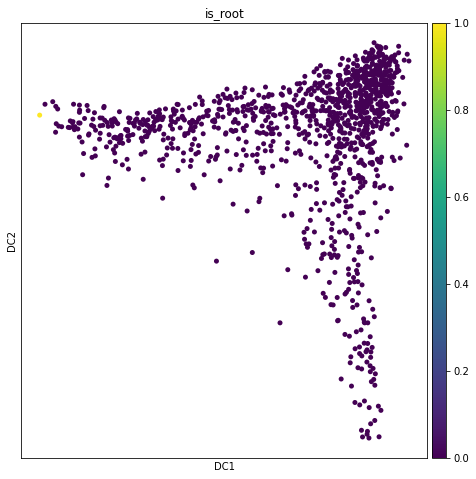

In [41]:
# Get DC1 min, DC2 max cell as root (should be the outer most stemm cell
c1 = adata_adt_ery.obsm['X_diffmap'][:,1].argmin()
c2 = adata_adt_ery.obsm['X_diffmap'][:,2].argmin()

#c1 == c2

adata_adt_ery.uns['iroot'] = c1

        
#check if correct
adata_adt_ery.obs['is_root'] = [1 if idx==adata_adt_ery.obs_names[c1] else 0 for idx in adata_adt_ery.obs_names]
sc.pl.diffmap(adata_adt_ery, color='is_root', components='1,2', frameon=True)


In [42]:
adata_adt_ery

AnnData object with n_obs × n_vars = 1199 × 140
    obs: 'n_antibodies_by_counts', 'total_counts', 'iso_count', 'leiden_res0.5_sub', 'leiden_final', 'rna_ann', 'test', 'celltype', 'is_root'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts'
    uns: 'iso_count_fltr_colors', 'leiden', 'leiden_res0.3_colors', 'leiden_res0.5_colors', 'leiden_res0.5_sub_colors', 'leiden_res0.8_colors', 'leiden_res1_colors', 'leiden_temp_colors', 'neighbors', 'pca', 'predicted_doublet_colors', 'rank_leiden_res0.5', 'umap', 'leiden_final_colors', 'rna_ann_colors', 'test_colors', 'celltype_colors', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

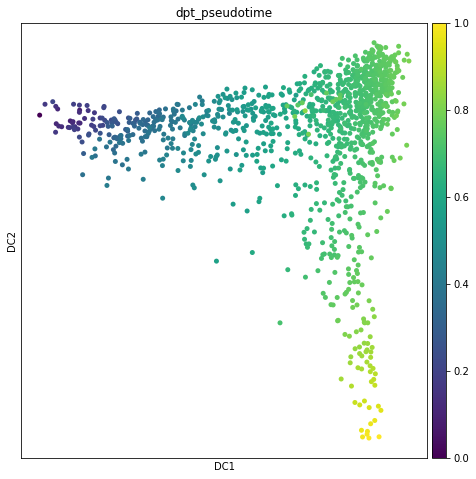

In [43]:
sc.tl.dpt(adata_adt_ery)
sc.pl.diffmap(adata_adt_ery, color='dpt_pseudotime', components='1,2', frameon=True)

In [44]:
# Transfer back to full object
adata_adt_sub.obs['pseudotime_order_ADT'] = adata_adt_ery.obs['dpt_pseudotime']

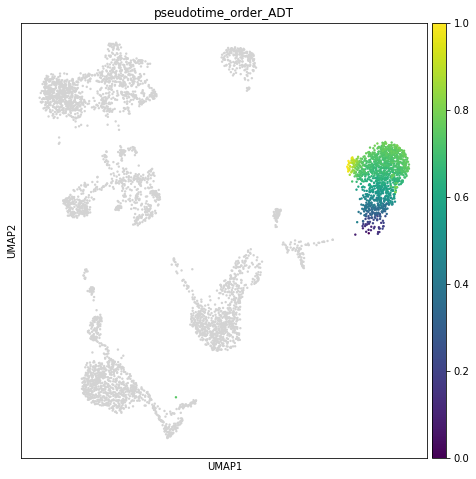

In [45]:
sc.pl.umap(adata_adt_sub, color='pseudotime_order_ADT')

## Write output

Save RNA data

In [46]:
# Check the object
adata_rna_sub

AnnData object with n_obs × n_vars = 5227 × 15422
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'size_factors', 'phase', 'leiden_res0.5_tsub', 'leiden_final', 'adt_ann', 'test', 'celltype', 'pseudotime_order_GEX'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'leiden', 'leiden_final_colors', 'leiden_res0.3_colors', 'leiden_res0.5_colors', 'leiden_res0.5_tsub_colors', 'leiden_res0.8_colors', 'leiden_res1_colors', 'neighbors', 'pca', 'phase_colors', 'predicted_doublet_colors', 'rank_genes_res0.5', 'rg_res0.5_tsub', 'umap', 'adt_ann_colors', 'test_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [47]:
# Create slim rna adata
adata_rna_slim = ad.AnnData(X=adata_rna_sub.X,
                            obs=adata_rna_sub.obs[['n_genes_by_counts','pct_counts_mt','size_factors','phase',
                                                  'leiden_final','adt_ann','celltype','pseudotime_order_GEX']],
                           var=adata_rna_sub.var)

adata_rna_slim.obs = adata_rna_slim.obs.rename(columns={'celltype':'cell_type'})
adata_rna_slim.var['feature_types'] = 'GEX'

adata_rna_slim.uns = adata_rna_sub.uns
# remove colors in uns
col_labs = [lab for lab in list(adata_rna_slim.uns.keys()) if '_colors' in lab]
for col in col_labs:
    del(adata_rna_slim.uns[col])

adata_rna_slim.obsm = adata_rna_sub.obsm
adata_rna_slim.varm = adata_rna_sub.varm
adata_rna_slim.obsp = adata_rna_sub.obsp
adata_rna_slim.layers['counts'] = adata_rna_sub.layers['counts']

In [48]:
adata_rna_slim

AnnData object with n_obs × n_vars = 5227 × 15422
    obs: 'n_genes_by_counts', 'pct_counts_mt', 'size_factors', 'phase', 'leiden_final', 'adt_ann', 'cell_type', 'pseudotime_order_GEX'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_res0.5', 'rg_res0.5_tsub', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [49]:
# Save
adata_rna_slim.write_h5ad('data/s1d1/cite/s1d1_CITE_GEX_merged.h5ad')

... storing 'feature_types' as categorical


Save ADT data

In [50]:
# Check the object
adata_adt_sub.var_names

Index(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', length=140)

In [51]:
# Create slim adt adata
adata_adt_slim = adata_adt_sub.copy()

adata_adt_slim.obs = adata_adt_sub.obs[['n_antibodies_by_counts','total_counts','iso_count',
                                                  'leiden_final','rna_ann','celltype','pseudotime_order_ADT']]

adata_adt_slim.obs = adata_adt_slim.obs.rename(columns={'celltype':'cell_type'})
adata_adt_slim.var['feature_types'] = 'ADT'

adata_adt_slim.uns = adata_adt_sub.uns
# remove colors in uns
col_labs = [lab for lab in list(adata_adt_slim.uns.keys()) if '_colors' in lab]
for col in col_labs:
    del(adata_adt_slim.uns[col])

adata_adt_slim.obsm = adata_adt_sub.obsm
adata_adt_slim.varm = adata_adt_sub.varm
adata_adt_slim.obsp = adata_adt_sub.obsp
adata_adt_slim.layers['counts'] = adata_adt_sub.layers['counts']

In [52]:
adata_adt_slim.var_names

Index(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', length=140)

In [53]:
adata_adt_slim.write_h5ad('data/s1d1/cite/s1d1_CITE_ADT_merged.h5ad')

... storing 'feature_types' as categorical
